In [10]:
%matplotlib inline

import matplotlib.pyplot as plt

import cv2
import numpy as np

from invorec import common

In [12]:
sift = cv2.xfeatures2d.SIFT_create()
# surf = cv2.xfeatures2d.SURF_create()

im1 = cv2.imread('../../MobileInvoiceRecognition/meta_data/std_invoice_img.jpeg')
# im1 = cv2.imread('/Users/yangli/Documents/4.png')
gray1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)

im2 = cv2.imread('/home/mobile/data/invoice-edges/-64r134oif4m7pcMw8XHZjYlVxubL-czG6CVv9zBMGW4O1JL8H7GLg_nk1g8hUBy(2).jpg')
# im2 = cv2.imread('../../orientation_detection/data/test/inputs/samsung3700/Iw9vvQe5Fu7LOdR3LCvvUj0ZdlXDI8CXaI8M8-__hjVr2LTURFYFSoMpDch7MhwD.jpg')
gray2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

In [16]:
gray1 = common.resize_image(gray1, 0.7)
kp1, des1 = sift.detectAndCompute(gray1, None)

gray2 = common.resize_image(gray2, 0.9)
kp2, des2 = sift.detectAndCompute(gray2, None)

In [17]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

MIN_MATCH_COUNT = 15
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    h,w = gray1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(gray2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print "Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT)
    matchesMask = None

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

matchImg = cv2.drawMatches(gray1,kp1,gray2,kp2,good,None,**draw_params)

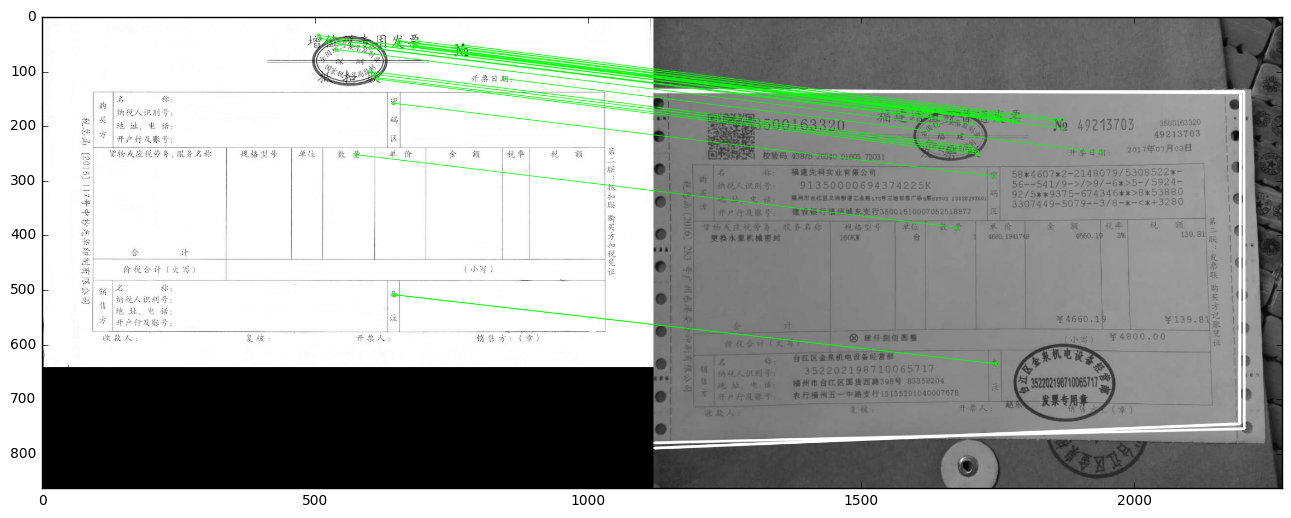

In [18]:
plt.figure(figsize=(16,16))
plt.imshow(matchImg, 'gray')
plt.show()